In [ ]:
!pip install tensorflow numpy matplotlib wandb datasets arabic_reshaper python_bidi

In [ ]:
!pip install -U datasets

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import wandb
import os
import re
import keras
from warnings import filterwarnings
from datasets import load_dataset
from PIL import Image
from arabic_reshaper import arabic_reshaper
from bidi.algorithm import get_display
from io import BytesIO
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import StringLookup
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.backend import ctc_decode


filterwarnings('ignore')
os.environ.pop("WANDB_X_REQUIRE_LEGACY_SERVICE", None)
plt.rcParams["font.family"] = "DejaVu Sans"

### DataSet class

In [ ]:
class DataSet:
    def __init__(self, data_path="aamijar/muharaf-public", splits=["train", "validation", "test"]):
        self.data_path = data_path
        self.splits = splits

        self.dataset = load_dataset(data_path)

        def clean_text(text):
            if not text or not isinstance(text, str):
                return ""

            text = re.sub(r"[\t\n\r]", " ", text)

            text = re.sub(r"[^\u0600-\u06FF0-9\s]", "", text)

            text = re.sub(r"\s+", " ", text).strip()

            return text

        def is_arabic(text):
            if not text or not isinstance(text, str):
                return False

            arabic_chars = re.findall(r'[\u0600-\u06FF]', text)
            total_chars = len(text.strip())
            if total_chars == 0:
                return False

            arabic_ratio = len(arabic_chars) / total_chars
            return arabic_ratio >= 0.3

        def filter_arabic(example):
            return is_arabic(example["text"])

        def preprocess(example):
            text = example["text"]
            text = clean_text(text)
            example["text"] = text
            return example

        def sort_key(example):
            return len(example["text"])

        self.train = self.dataset["train"].map(preprocess).filter(filter_arabic)
        self.validation = self.dataset["validation"].map(preprocess).filter(filter_arabic)
        self.test = self.dataset["test"].map(preprocess).filter(filter_arabic)

        self.train = sorted(self.train, key=sort_key)
        self.validation = sorted(self.validation, key=sort_key)
        self.test = sorted(self.test, key=sort_key)

    def __resize_with_padding(self, img, target_size):
        target_width, target_height = target_size
        original_width, original_height = img.size

        ratio = min(target_width / original_width, target_height / original_height)
        new_size = (int(original_width * ratio), int(original_height * ratio))
        resized = img.resize(new_size, Image.Resampling.LANCZOS)

        # Convert image to grayscale and pad it with white (255) background
        # padded_img = Image.new('L', (target_width, target_height), 255)
        # paste_position = ((target_width - new_size[0]) // 2, (target_height - new_size[1]) // 2)
        # padded_img.paste(resized.convert('L'), paste_position)

        # Create a new RGB image with white (255,255,255) background
        padded_img = Image.new('RGB', (target_width, target_height), (255, 255, 255))
        paste_position = ((target_width - new_size[0]) // 2, (target_height - new_size[1]) // 2)
        padded_img.paste(resized, paste_position)

        return padded_img

    def preprocess(self, target_size=(100, 60),normalize=True):
        def process_split(split):
            images = []
            texts = []
            for sample in split:
                img = sample["image"]
                if isinstance(img, dict) and "bytes" in img:
                    img = Image.open(BytesIO(img["bytes"]))
                resized_img = self.__resize_with_padding(img, target_size)
                images.append(np.array(resized_img))
                texts.append(sample["text"])

            if normalize:
                return np.array(images), np.array(texts)
            return np.array(images), np.array(texts)

        train_images, train_texts = process_split(self.train)
        validation_images, validation_texts = process_split(self.validation)
        test_images, test_texts = process_split(self.test)

        return (train_images, train_texts), (validation_images, validation_texts), (test_images, test_texts)

    def plot_train_images(self, nrow=2, ncol=2, figsize=(10, 10)):
        fig, axes = plt.subplots(nrow, ncol, figsize=figsize)
        axes = axes.flatten()

        total_images = min(len(self.train), nrow * ncol)

        for i in range(total_images):
            sample = self.train[i]
            img = sample["image"]
            if isinstance(img, dict) and "bytes" in img:
                img = Image.open(BytesIO(img["bytes"]))
            img = self.__resize_with_padding(img, (256, 60))
            ax = axes[i]
            ax.imshow(img, cmap="gray")

            reshaped_text = arabic_reshaper.reshape(sample["text"])
            bidi_text = get_display(reshaped_text)
            ax.set_title(bidi_text, fontsize=10)
            ax.axis("off")

        for j in range(total_images, len(axes)):
            axes[j].axis("off")

        plt.tight_layout()
        plt.show()

# Start Experiments

## load the data

README.md:   0%|          | 0.00/2.35k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/385M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/399M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/403M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/59.3M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/70.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/22092 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1069 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1334 [00:00<?, ? examples/s]

Map:   0%|          | 0/22092 [00:00<?, ? examples/s]

Filter:   0%|          | 0/22092 [00:00<?, ? examples/s]

Map:   0%|          | 0/1069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1069 [00:00<?, ? examples/s]

Map:   0%|          | 0/1334 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1334 [00:00<?, ? examples/s]

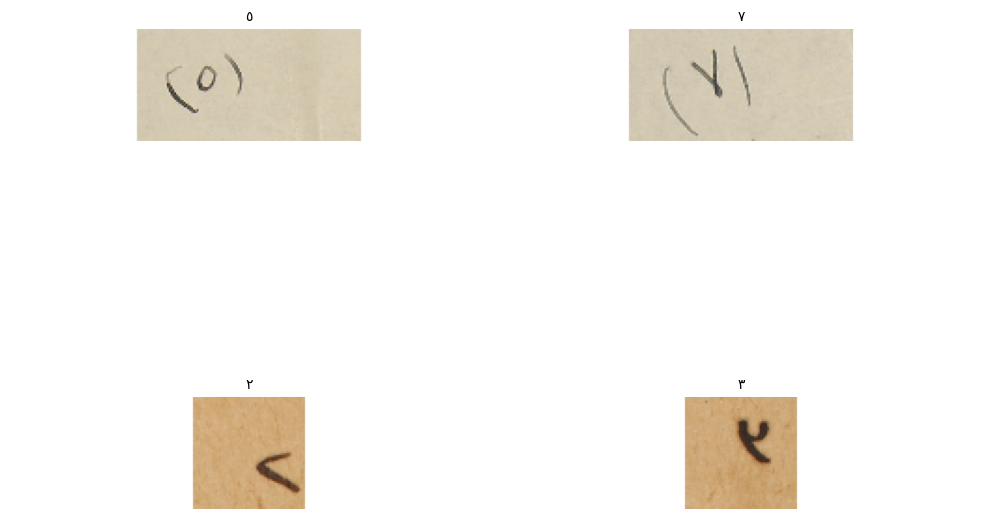

In [ ]:
dataset = DataSet()
dataset.plot_train_images()

## preprocess the data

In [ ]:
(train_images,train_texts),(validation_images,validation_texts),(test_images,test_texts)=dataset.preprocess()

In [ ]:
print("Train image shape:", train_images.shape)

Train image shape: (21045, 60, 100, 3)


In [ ]:
list=[]

all_text = np.concatenate((train_texts,validation_texts,test_texts))


for text in all_text:
    if not text:
        continue

    temp = [ord(char) for char in text]
    list.append(temp)

number_set=set()
for numbers in list:
    for number in numbers:
        number_set.add(number)

print(f"Number char in the data {len(number_set)}")

Number char in the data 74


In [ ]:
max_text=0
for text in all_text:
    max_text = max(max_text, len(text))

print(f"Max text length {max_text}")

Max text length 181


In [ ]:
all_text = np.concatenate((train_texts,validation_texts,test_texts))

char_set=set()

for text in all_text:
    if not text:
        continue
    chars = [char for char in text]

    for char in chars:
        char_set.add(char)
char_set = sorted(char_set)

print(f"The char in vocab {char_set}")

The char in vocab [' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '،', '؛', '؟', 'ء', 'آ', 'أ', 'ؤ', 'إ', 'ئ', 'ا', 'ب', 'ة', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ـ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ى', 'ي', 'ً', 'ٌ', 'ٍ', 'َ', 'ُ', 'ِ', 'ّ', 'ْ', '٠', '١', '٢', '٣', '٤', '٥', '٦', '٧', '٨', '٩', 'ڤ', 'ڨ', '۳', '۷', '۹']


## Create a string lookup for convert the string to numbers

In [ ]:
from tensorflow.keras.layers import StringLookup

char_to_num = StringLookup(vocabulary=char_set,  mask_token=None )

num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

In [ ]:
print(f"The vocabulary is {char_to_num.get_vocabulary()}")

The vocabulary is ['[UNK]', np.str_(' '), np.str_('0'), np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('8'), np.str_('9'), np.str_('،'), np.str_('؛'), np.str_('؟'), np.str_('ء'), np.str_('آ'), np.str_('أ'), np.str_('ؤ'), np.str_('إ'), np.str_('ئ'), np.str_('ا'), np.str_('ب'), np.str_('ة'), np.str_('ت'), np.str_('ث'), np.str_('ج'), np.str_('ح'), np.str_('خ'), np.str_('د'), np.str_('ذ'), np.str_('ر'), np.str_('ز'), np.str_('س'), np.str_('ش'), np.str_('ص'), np.str_('ض'), np.str_('ط'), np.str_('ظ'), np.str_('ع'), np.str_('غ'), np.str_('ـ'), np.str_('ف'), np.str_('ق'), np.str_('ك'), np.str_('ل'), np.str_('م'), np.str_('ن'), np.str_('ه'), np.str_('و'), np.str_('ى'), np.str_('ي'), np.str_('ً'), np.str_('ٌ'), np.str_('ٍ'), np.str_('َ'), np.str_('ُ'), np.str_('ِ'), np.str_('ّ'), np.str_('ْ'), np.str_('٠'), np.str_('١'), np.str_('٢'), np.str_('٣'), np.str_('٤'), np.str_('٥'), np.str_('٦'), np.str_('٧'), np.str_('٨'), np.str_('٩'), np.str

## Convert the image to be suitable for ResNet50

In [ ]:
train_images = preprocess_input(train_images)
validation_images = preprocess_input(validation_images)
test_images = preprocess_input(test_images)

## Convert the data to tenserflow dataset

In [ ]:
def encode_data(image, label):
    img = tf.convert_to_tensor(image)

    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))

    return {"image": img, "label": label}

In [ ]:
def prepare_dataset(images,texts,padded_batch=16):
    data = tf.data.Dataset.from_tensor_slices((images, texts))
    data = (data.map(encode_data, num_parallel_calls=tf.data.AUTOTUNE)
                                  .padded_batch(padded_batch)
                                  .prefetch(buffer_size=tf.data.AUTOTUNE))
    return data

In [ ]:
train_dataset = prepare_dataset(train_images, train_texts,4)
validation_dataset = prepare_dataset(validation_images, validation_texts,4)
test_dataset = prepare_dataset(test_images, test_texts,4)

## Implementation ctc layer
This is a custom Keras layer that implements the Connectionist Temporal Classification (CTC) loss function, commonly used for sequence learning tasks like speech recognition or handwriting recognition.

In [ ]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        """
        Defines the forward pass of the layer where the computation happens
        :param y_true: ground truth labels
        :param y_pred: model predictions
        :return: Returns the predictions unchanged
        """

        # Gets the batch size (number of samples in the batch) from y_true and converts it to int64.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")

        # Gets the sequence length of the predictions (second dimension of y_pred) and converts to int64.
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")

        # Gets the sequence length of the labels (second dimension of y_true) and converts to int64.
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        # Creates a tensor of shape (batch_size, 1) where each element is the input sequence length.
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        # Creates a tensor of shape (batch_size, 1) where each element is the label sequence length.
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred



## Build the model use ResNet50 base model

In [ ]:
def build_model():
    base_model=tf.keras.applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(60,100,3),
    )

    imgs = tf.keras.layers.Input(shape=(60, 100, 3), name="image", dtype="float32")
    labels = tf.keras.layers.Input(name="label", shape=(None,), dtype="float32")

    x=base_model(imgs, training=False)

    x = keras.layers.Resizing(60, 256)(x)

    new_shape = (x.shape[2], x.shape[1] * x.shape[3])
    x = tf.keras.layers.Reshape(new_shape, name="reshape")(x)

    x = tf.keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = tf.keras.layers.BatchNormalization(name="BatchNormalization3")(x)
    x = tf.keras.layers.Dropout(0.5, name="dropout1")(x)

    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)

    x = tf.keras.layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation="softmax",name="dense2")(x)

    output = CTCLayer(name="ctc_loss")(labels, x)
    model = tf.keras.models.Model(inputs=[imgs, labels], outputs=output)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,clipvalue=1.0))

    return model

model=build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 60, 100,   │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 2, 4,      │ 23,587,712 │ image[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing (Resizing) │ (None, 60, 256,   │          0 │ resnet50[0][0]    │
│                     │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 256,       │          0 │ resizing[0][0]    │
│                     │ 122880)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 256, 64)   │  7,864,384 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BatchNormalization3 │ (None, 256, 64)   │        256 │ dense1[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout1 (Dropout)  │ (None, 256, 64)   │          0 │ BatchNormalizati… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 256, 256)  │    197,632 │ dropout1[0][0]    │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 256, 128)  │    164,352 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 256, 76)   │      9,804 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 256, 76)   │          0 │ label[0][0],      │
│                     │                   │            │ dense2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 31,824,140 (121.40 MB)

 Trainable params: 31,770,892 (121.20 MB)

 Non-trainable params: 53,248 (208.00 KB)

## Build a edit distance calculate

In [ ]:
test_images = []
test_labels = []

for batch in test_dataset:
    test_images.append(batch["image"])
    test_labels.append(batch["label"])

In [ ]:
def calculate_edit_distance(labels, predictions):
    saprse_labels = tf.sparse.from_dense(labels)

    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]

    predictions_decoded = tf.keras.backend.ctc_decode(

        predictions, input_length=input_len, greedy=False, beam_width=100)[0][0]
    sparse_predictions =tf.sparse.from_dense(predictions_decoded)

    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceMetrics:
    def __init__(self, prediction_model):
        self.prediction_model = prediction_model
        self.edit_distances = []

    def evaluate(self, images, labels):
        for i in range(len(images)):
            label = labels[i]
            prediction = self.prediction_model.predict(images[i])
            edit_distance = calculate_edit_distance(label, prediction).numpy()
            self.edit_distances.append(edit_distance)

        average_edit_distance = np.mean(self.edit_distances)
        return average_edit_distance

## Build BatchLossLogger to save loss by step


In [ ]:
class BatchLossLogger(Callback):
    def on_train_begin(self, logs=None):
        self.batch_losses = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs.get('loss'))

## Train thee model

In [ ]:
epochs = 10
early_stopping_patience = 2

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=early_stopping_patience,
    restore_best_weights=True
)

batch_loss_logger = BatchLossLogger()

In [ ]:
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=[batch_loss_logger, early_stopping])

Epoch 1/10
5262/5262 ━━━━━━━━━━━━━━━━━━━━ 984s 177ms/step - loss: 627.5601 - val_loss: 1254.9546
Epoch 2/10
5262/5262 ━━━━━━━━━━━━━━━━━━━━ 888s 169ms/step - loss: 359.9553 - val_loss: 1302.8790
Epoch 3/10
5262/5262 ━━━━━━━━━━━━━━━━━━━━ 880s 167ms/step - loss: 362.2003 - val_loss: 1273.1923
Epoch 4/10
5262/5262 ━━━━━━━━━━━━━━━━━━━━ 885s 168ms/step - loss: 361.2654 - val_loss: 907.5991
Epoch 5/10
5262/5262 ━━━━━━━━━━━━━━━━━━━━ 877s 167ms/step - loss: 356.3698 - val_loss: 1532.9187
Epoch 6/10
5262/5262 ━━━━━━━━━━━━━━━━━━━━ 896s 170ms/step - loss: 345.4688 - val_loss: 1620.3873
Epoch 7/10
5262/5262 ━━━━━━━━━━━━━━━━━━━━ 876s 166ms/step - loss: 343.9082 - val_loss: 1538.0182
Epoch 8/10
5262/5262 ━━━━━━━━━━━━━━━━━━━━ 874s 166ms/step - loss: 345.2440 - val_loss: 1137.6494
Epoch 9/10
5262/5262 ━━━━━━━━━━━━━━━━━━━━ 878s 167ms/step - loss: 342.5578 - val_loss: 1098.0593
Epoch 10/10
5262/5262 ━━━━━━━━━━━━━━━━━━━━ 927s 168ms/step - loss: 342.4201 - val_loss: 1254.6792


In [ ]:
model.save("resnet50.h5")

## Visualize the loss plot

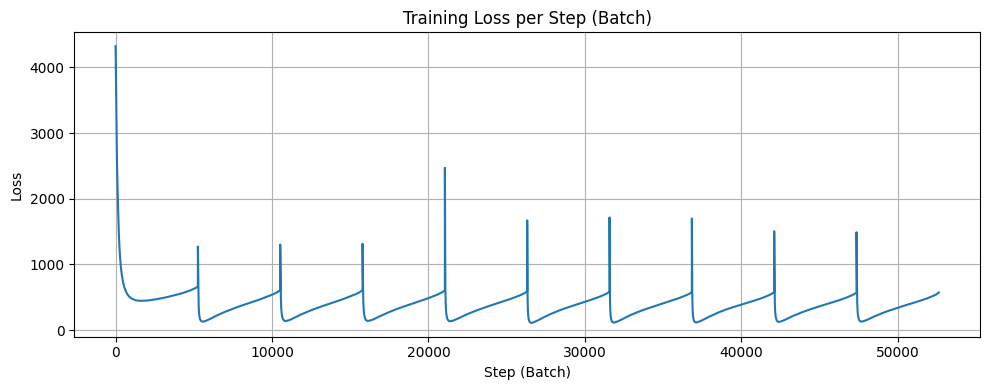

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(batch_loss_logger.batch_losses)
plt.title("Training Loss per Step (Batch)")
plt.xlabel("Step (Batch)")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

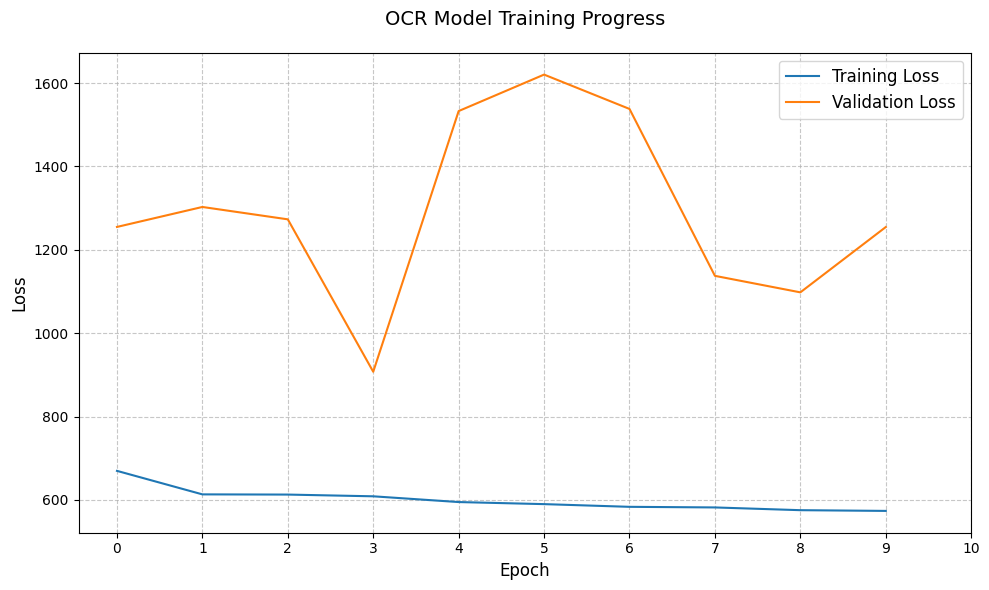

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title("OCR Model Training Progress", fontsize=14, pad=20)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)

max_epoch = len(history.history['loss'])
plt.xticks(range(0, max_epoch+1, max(1, max_epoch//10)))

plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

## Inference

In [ ]:
prediction_model = keras.models.Model(
    inputs=model.inputs[0],
    outputs=model.get_layer("dense2").output
)

In [ ]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = ctc_decode(pred, input_length=input_len, greedy=True)[0][0]

    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)

    return output_text

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
['ال  ان اة ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا اة', '', 'ال ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا  ا ا ا ا ا ا اة', 'ا   ال  ال  ال  ا ']


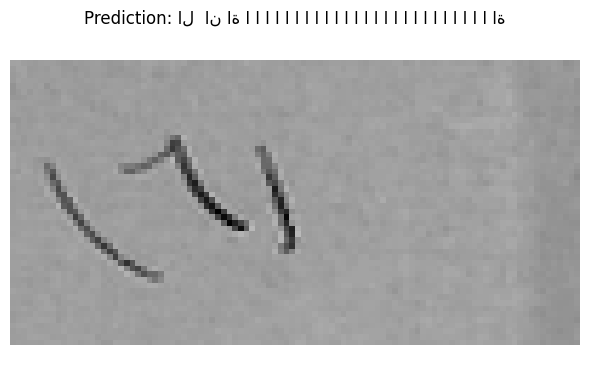

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
['', '', 'ا', '']


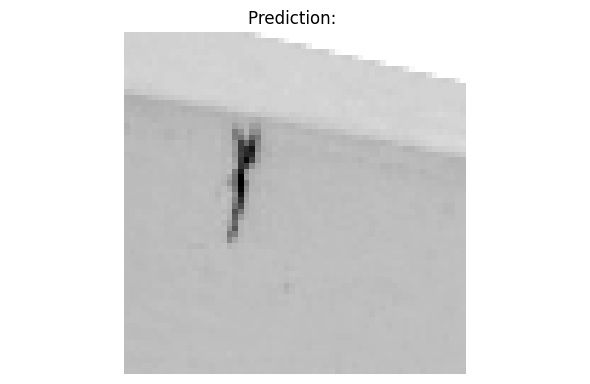

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
['', '', '', '']


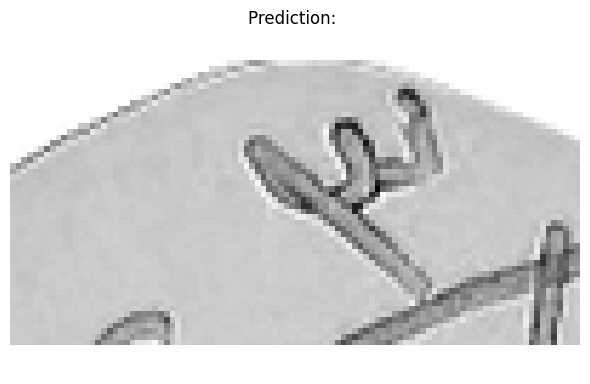

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
['', '', '', '']


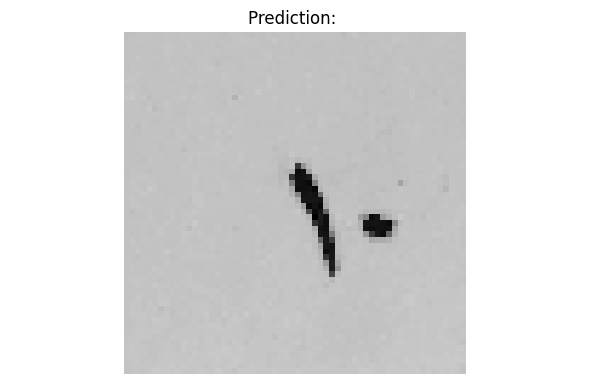

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
['', 'ا    ال ا ال  ال ال ا ا ا و', '', 'ال ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا اة']


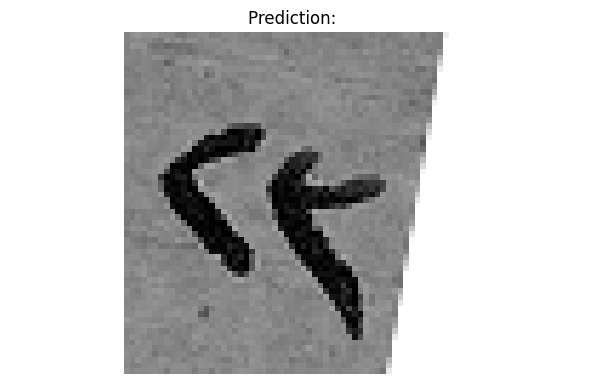

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
['ال ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا  اة', '', '', 'ال ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا اا']


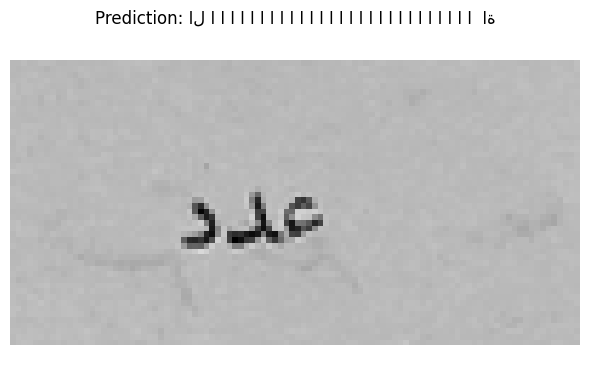

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
['', 'ال ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا اة', 'ا  ال ا ال ال ال ا ال ال الة الن ال ال ال ال ا', 'ا']


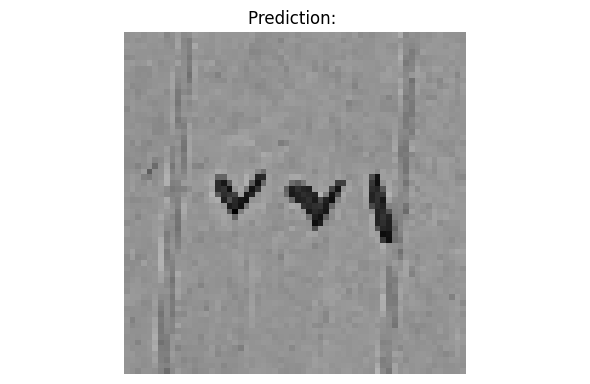

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
['ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا اا', '', 'ا', 'ال  ا ا ا ال ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا اة']


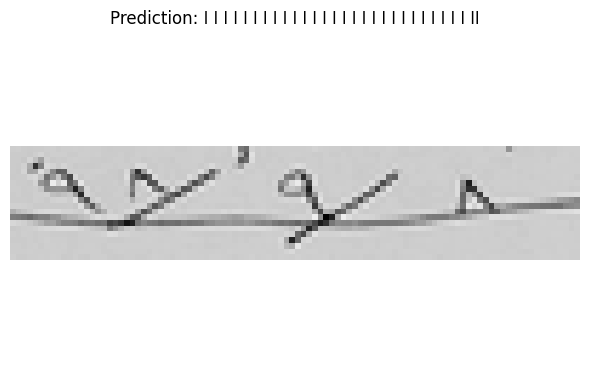

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
['ال  ان اة ا ال ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا اة', 'ال  ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ا ال ا ا ا ال ال ال  ال اة', '', '']


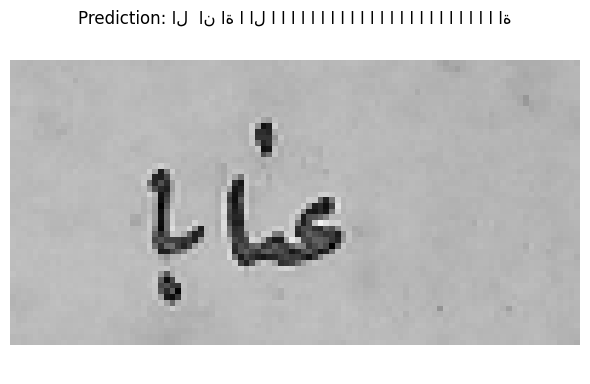

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
['', '', '', 'ا']


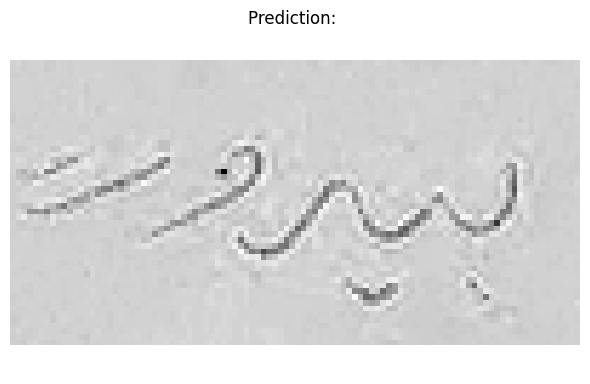

In [ ]:
for batch in test_dataset.take(10):
    batch_images = batch["image"]
    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    print(pred_texts)
    img = batch_images[0]
    pred_text = pred_texts[0]

    if len(img.shape) == 3:
        img = (img * 255.0)
        img = img[:, :, 0]
    elif len(img.shape) == 2:
        img = (img * 255.0).numpy()

    plt.figure(figsize=(6, 4))
    plt.imshow(img, cmap="gray")
    plt.title(f"Prediction: {pred_text}")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

